# Economic Models

Python is a very powerfull tool when dealing with economic models. It is widely used in quantitative macroeconomic fields and others. In this section we will learn some applications of Python using models. If you have a special interest it is highly recommendable to visit the website [QuantEcon](https://python.quantecon.org/intro.html) created by Thomas J. Sargent and John Stachurski where a large amount of model applications can be found. 

## Collusion with Cournot competition

The first model that we will see is a model of collusion with Bertrand competition. Remember in such a model firms compete in quantities. For this example we will be following the notes [here](http://janboone.github.io/competition_policy_and_regulation/Collusion_Cournot/Collusion_Cournot.html).

Let's present the model.

### demand and cost

The demand is a linear curve $p_i(x_i,x_j) = 1-x_i-bx_j$ where $b \in (0,1]$ determines the elasticity of substitution between the goods. With $b=1$ the goods are perfect substitutes, with $b<1$ the goods are differentiated. 

Marginal costs are constant with $c(x) = cx$. If we would like to introduce a fixed cost, $c(x) = cx + f$ for some $f>0$ we need to make sure that if the firm remains inactive the cost is $0$ ($c(0) = 0$). Let's try to write it in Python. 

In [12]:

def demand(x1,x2,b):
    return 1-x1-b*x2

def cost(x,c):
    if x == 0:
     cost = 0
    else:
     cost = c*x
    return cost



### Profits
They are defined by:
$$\pi(x_i,x_j) = p_i(x_i,x_j)x_i-c(x_i) $$

And we can translate this to Python by:

In [13]:
def profit(x1,x2,c1,b):
    return demand(x1,x2,b)*x1-cost(x1,c1)


### Reaction Functions

Under Cournot competition the decision of one firm takes as given the choice of the other. That is, $x_1^*,x_2^*$ is a Nash equilibrium if and only if

$$x_i ^* = \arg \max_{x_i}\pi(x_i,x_j ^*)$$

For each $i \neq j \in (1,2)$. To find such a function we would take the first order condition equal to 0 and solve. However, with Python we can directly look for the profit maximizing outcome. 

The [scipy optimze](https://docs.scipy.org/doc/scipy-0.14.0/reference/optimize.html) library has a number of routines to optimize functions. They are all defined as minimization problems, so to maximize we just need to multiply by $-1$. 

In [1]:
!pip install scipy

In [14]:
from scipy import optimize,arange
def reaction(x2,c1,b):
    x1 = optimize.brute(lambda x: -profit(x,x2,c1,b), ((0,1,),)) # brute minimizes the function;
                                                                 # when we minimize -profits, we maximize profits
    return x1[0]
    

### Equilibrium as fixed point

To find for the equilibrium we are looking for the fixed point of both reaction functions. Let $r_i(x_j)$ denote firm $i's$ optimal response to $j's$ output level $x_j$. Then we need to find a point such that:

$$\begin{pmatrix}
  x_1^* \\
  x_2^* \\
\end{pmatrix} = \begin{pmatrix}
 r_1( x_1^*) \\
  r_2(x_2^*) \\
\end{pmatrix}$$

Defining the vector function $f(x_1,x_2)$ as

$$f(x) = \begin{pmatrix}
 r_1( x_1^*) \\
  r_2(x_2^*) \\
\end{pmatrix} $$ we are looking for a point $x^*=(x_1^* ,x_2^*)$ such that $x^* = f(x^*)$.  So the problem to find the fixed point is equivalent to find the $x^*$ such that $x^* - f(x^*)=0$. We can define this function in Python as:

In [15]:
from numpy import array
def vector_reaction(x,param): # vector param = (b,c1,c2)
    return array(x)-array([reaction(x[1],param[1],param[0]),reaction(x[0],param[2],param[0])])



Where `param` = $[b,c_1,c_2]$.

### Cournot equilibrium

To calculate the equilibrium we just need to find the point at which the previous function equals to 0. To do that we will use `fsolve` from `scipy.optimize`.  Let's see how it works:

In [17]:
param = [1,0,0]   # Give the parameter values
x0 = [0.1,0.1]    # Initial guess

ans  = optimize.fsolve(vector_reaction, x0, args=(param))
print(ans)


[0.33332648 0.33332648]


### Collusion

The interesting part about this model is to see what would happen if the firms would instead maximize the joint profit function, instead of competing against each other. To simplify, we would focus on a case where firms are symmetric $c_1=c_2=c$ and have a symmetric output $x_1=x_2=x$. 

It is then of our interest to see if the firms have incetives to collute, and wether the collusion would be sustained period after period.

We know that if the firms collude, the expected profit is $\pi(x,x) \frac{1}{1-\delta}$. Furthermore, if a firm decides to deviate, it will change a price slightly below the monopoly price. In the deviation period it will earn almost the monopoly profit, but for then on profits are zero since the firm will be punished by the other firm.  Therefore, for collusion to be sustained we need:

$$\pi(x,x) \frac{1}{1-\delta} \geq \max_{\hat{x}}\pi(\hat{x},x) + \frac{\delta}{1-\delta} \pi(x^*,x^*)$$

where $\delta$ is the discount factor and $\hat{x}$ is the optimal response of the firm to the opponent choosnig output level $x$.  

We can rewrite the previous inequality as $$\pi(x,x) \geq (1-\delta)\max_{\hat{x}}\pi(\hat{x},x) + \delta\pi(x^*,x^*)$$

In [18]:
def collusion_profits(x,b,c,delta): # we only do this for the symmetric case: c1 = c2 = c
    profits = profit(x,x,c,b)
    ans = optimize.fsolve(vector_reaction, x0, args = ([b,c,c]))
    if profits >= (1-delta)*profit(reaction(x,c,b),x,c,b)+delta*profit(ans[0],ans[1],c,b):
        industry_profits = 2*profits # profits can be sustained as collusion profits
    else:
        industry_profits = 0 # profits cannot be sustained as collusion profits
    return industry_profits




C:\Users\Sergi\AppData\Local\Temp\ipykernel_18664\2770697996.py:3: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  range_x = arange(0.25,ans[0],0.01)


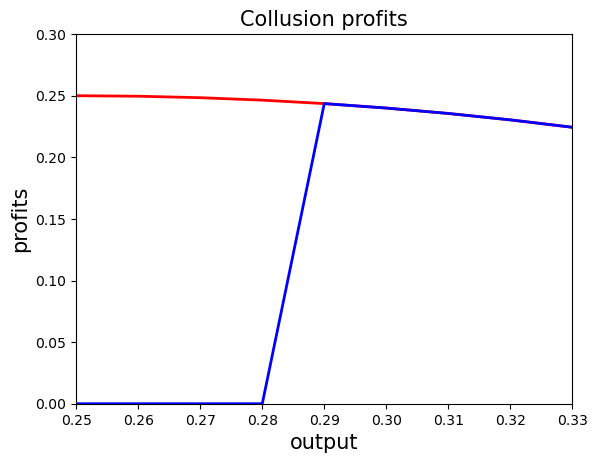

In [19]:
import matplotlib.pyplot as plt

range_x = arange(0.25,ans[0],0.01)
delta1 = 0.8
delta2 = 0.3
range_profits = [collusion_profits(x,1.0,0.0,delta1) for x in range_x]
range_profits2 = [collusion_profits(x,1.0,0.0,delta2) for x in range_x]

plt.clf()

plt.plot(range_x, range_profits,'-', color = 'r', linewidth = 2)
plt.plot(range_x, range_profits2,'-', color = 'b', linewidth = 2)
plt.title("Collusion profits",fontsize = 15)
plt.xlabel("output",fontsize = 15)
plt.ylabel("profits",fontsize = 15,rotation = 90)
plt.xlim(0.25,0.33)
plt.ylim(0.0,0.3)
plt.savefig('collusion.png')

### Solving the model symbolically. 

Follow the tutorial [here](https://janboone.github.io/municipality_healthcare_expenditure/solving_model.html).


# Computing Transitions in a Representative Agent Economy

In this section we will see how to compute a transition from one steady state to another after a MIT shock is introduced to the economy. 

## The model 
It is an optimal growth economy populated by a large number of identical infinitely lived households that maximize $$E\{\sum_{t=0}^\infty \beta^t u(c_t)\}$$ over consumption and leisure $u(c_t) = lnc_t$, subject to:
$$c_t+i_t=y_t$$
$$y_t=k_t^{1-\theta}(zh_t)^\theta$$
$$i_t = k_{t+1}-(1-\delta)k_t $$

For this exercice we will set the labor share $\theta=0.67$ and $h_t=0.31$ for every $t$, so population does not grow. 

The first thing we need to do is compute the initial steady state of the economy.  We will do it by matching $z$ to an annual capital-output ratio of $4$, and an investment-output ratio of $0.25$. 


To do that we will solve for the solution of the economy.  With a bit of algebra we can get:

$$k^* = zh^*\left[\frac{(1-\theta)\beta}{1-(1-\delta)\beta}\right]^{\frac{1}{\theta}}$$

Now we can impose that the capital-output ratio should be 4 and the investment-output ratio should be 0.25. With this we get that:

$$i^* =\delta k^* \leftrightarrow \delta =  \frac{0.25}{4} = 0.0625 $$

$$ c^* = y^* - i^*  = 1-0.25 = 0.75$$

$$ y^* = k^*(1-\theta) (zh^*)^\theta \leftrightarrow z = \left(\frac{y}{k^{*1-\theta}h^{*\theta}}\right)^{\frac{1}{\theta}} = 1.629 $$
And solving for $\beta$ gives: 
$$ \beta = 0.98 $$

## The new Steady State

The economy will face a productivity show that will doblue the productivity, so that $z_{new} = 2z$. 

The new values are: 
\begin{align*}
    k_{new}^*=2zh^*\bigg[\frac{(1-\theta)\beta}{1-(1-\delta)\beta}\bigg]^{\frac{1}{\theta}}
\end{align*}


\begin{align*}
    y_{new}^* = (2k^*)^{1-\theta}(2h^*)^{\theta}=2(k^{*1-\theta} (zh^*)^{\theta})=2
\end{align*}


\begin{align*}
   i_{new}^*= \delta k_{new}^* = 0.5
\end{align*}

\begin{align*}
    c_{new}^*= y_{new}^*-i_{new}^*=1.5
\end{align*}

## The transition
To move from one steady state to another we will need to use the law of motion of capital. This law of motion needs to satisfy the optimality condition (Euler equation), so for this reason our transition path will be characterized by $n$ Euler equaitons, that will be written only as a function of capital. So take the Euler equation as a function of capital: 

\begin{align*}
   k_{t+1}^{1-\theta} (z h_{t+1})^\theta + (1-\delta)k_{t+1}-k_{t+2}= \beta (k_{t}^{1-\theta} (z h_t)^\theta + (1-\delta)k_t-k_{t+1})((1-\theta)k_{t+1}^{-\theta}(z h_{t+1})^{\theta}+(1-\delta))
\end{align*}

The procedure to characterize the transition path is the following:
1. We need to characterize $n$ different periods Euler equations, so will will have $n$ equations and $n+2$ unknowns
2. To have an identified system of equations, we can establish the initial capital level, which is the initial steady state and also the final capital level, which is the second steady state capital value.
3. Once we have a perfect identified system of $n$ equations and $n$ unknowns we can solve for it. Notice that our $n$ unknowns are nothing else than the transition values of capital towards the steady state.

In [10]:
# Define the parameters and values that I have computed analytically: 
θ=0.67       # Labor Share         
h=0.31       # Labor
k_i=4        # Capital at initial steady state
i_i=0.25     # Investment at initial steady state
c_i=0.75     # Consumption at initial steady state
y_i=1        # Normalized Output at intial steady state
δ=i_i/k_i        # Depreciation
z=1/((k_i**(1 - θ) * h ** θ) ** (1/θ))             # Labor productivity
β= 1 / ((1-θ) * k_i **(-θ) * (z*h) ** θ + 1 - δ)   # Discount factor


In [11]:
# Values for the final steady state.
k_f=8
i_f=0.5
c_f=1.5
y_f=2
z=2*z    #Shock

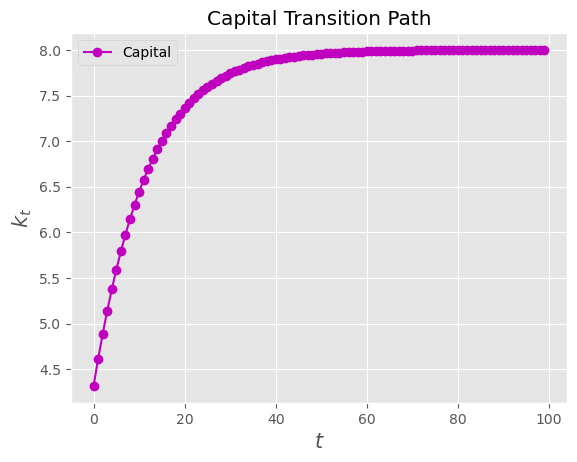

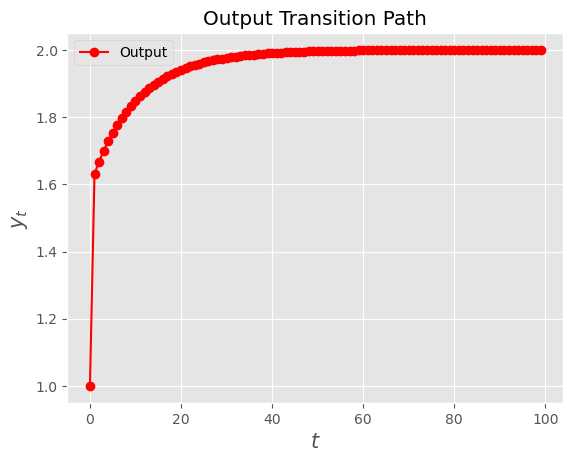

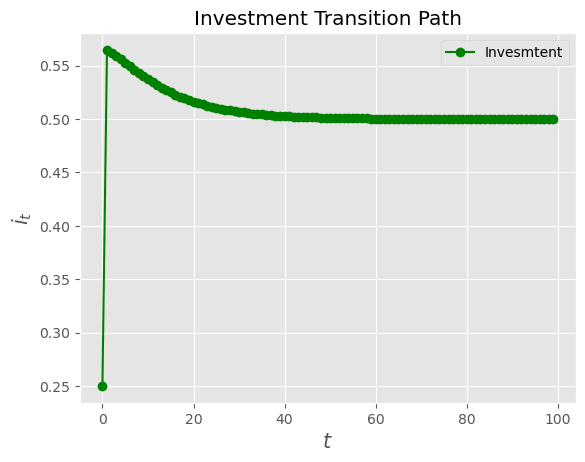

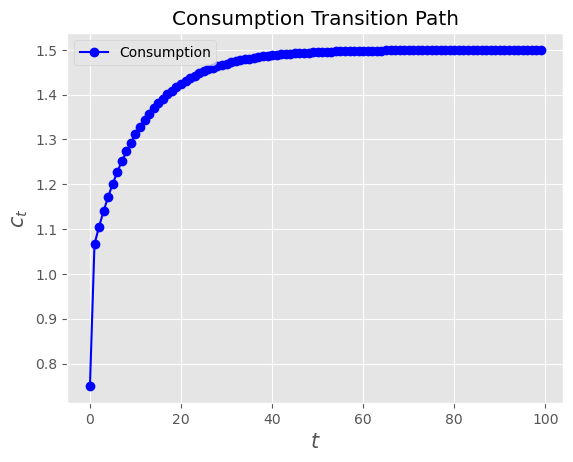

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
plt.style.use('ggplot')


########
# Define our variables:

def output(k,y_i=y_i): 
    y = list( k[:-1]**(1-θ)*(z*h)**θ)
    return np.array([[y_i]+y]).reshape(n,)


def investment (k,i_i=i_i):
    i = list(k[1:]-(1-δ)*k[:-1])
    return np.array([[i_i] + i]).reshape(n,)


def consumption(y,i):
     return y-i
    


#Characterize the transition path: 

n = 100 # Number of periods of transition


def transition_path(k):

    n = np.shape(k)[0] #amount of periods the transition takes to occur

    trans = np.zeros(n)
    k = np.concatenate((np.array([k_i]),k,np.array([k_f])))
    trans = k[1:-1]**(1-θ)*(z*h)**θ+(1-δ)*k[1:-1]-k[2:]-β*(k[0:-2]**(1-θ)*(z*h)**θ+(1-δ)*k[0:-2]-k[1:-1])*((1-θ)*k[1:-1]**(-θ)*(z*h)**θ+1-δ)

    return trans                     

#Define an initial guess: 

x0 = np.linspace(k_i,k_f,n)                 # Grid of n points between 4 and 8, which is the transition space. 
k_trans = fsolve(transition_path,x0)    # Solves the system of equations. Gives the transition path.


#Generate the transition path for the other variables:

## Output: 
y = output(k_trans)
## Investment: 
i_path = investment(k_trans)
## Consumption: 
c = consumption(y,i_path)
# Plots: 

def create_plots():
    fig, ax = plt.subplots()
    ax.plot(k_trans,'m-o',label="Capital")
    plt.ylabel("$k_t$",fontsize=15)
    plt.xlabel("$t$",fontsize=15)
    plt.legend()
    plt.title("Capital Transition Path")


    fig, ax = plt.subplots()
    ax.plot(y,'r-o',label = "Output")
    plt.ylabel("$y_t$",fontsize = 15)
    plt.xlabel("$t$",fontsize = 15)
    plt.legend()
    plt.title("Output Transition Path")

    fig, ax = plt.subplots()
    ax.plot(i_path,'g-o',label = "Invesmtent")
    plt.ylabel("$i_t$",fontsize = 15)
    plt.xlabel("$t$",fontsize = 15)
    plt.legend()
    plt.title("Investment Transition Path")

    fig, ax = plt.subplots()
    ax.plot(c,'b-o',label = "Consumption")
    plt.ylabel("$c_t$",fontsize = 15)
    plt.xlabel("$t$",fontsize = 15)
    plt.legend()
    plt.title("Consumption Transition Path")

create_plots()


### (Class Exercice!) Unexpected shocks. Let the agents believe productivity $z_t$ doubles once and for all periods. However, after 10 periods, surprise the economy by cutting the productivity $z_t$ back to its original value. Compute the transition for savings, consumption, labor and output.

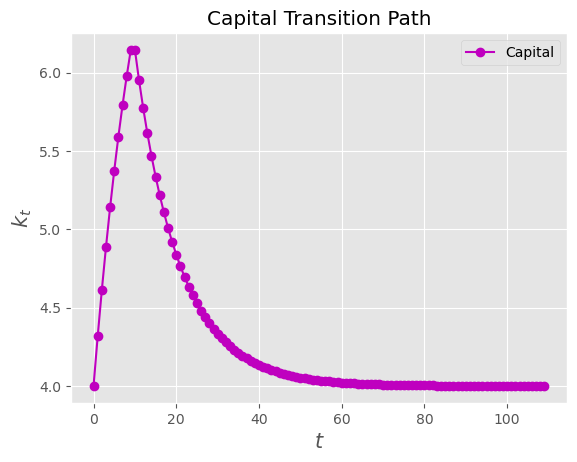

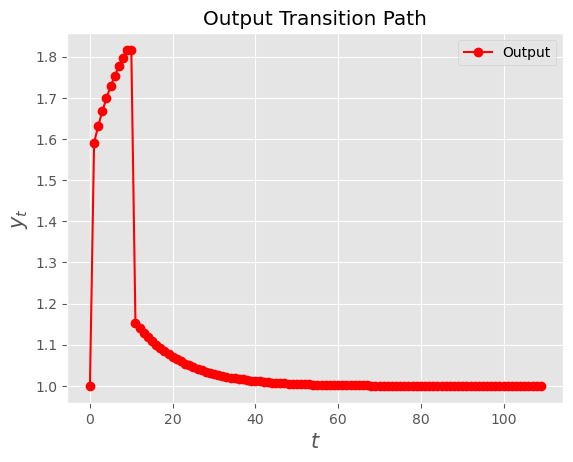

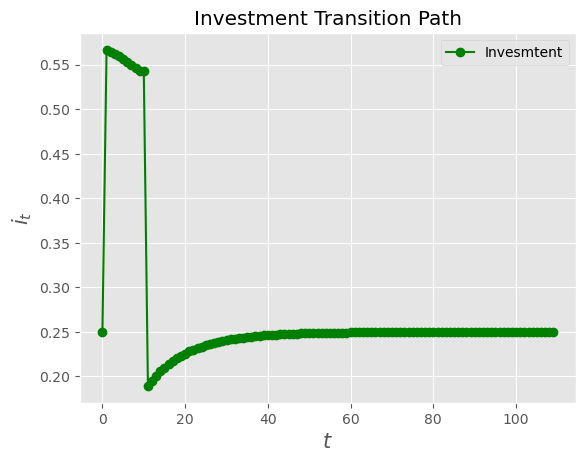

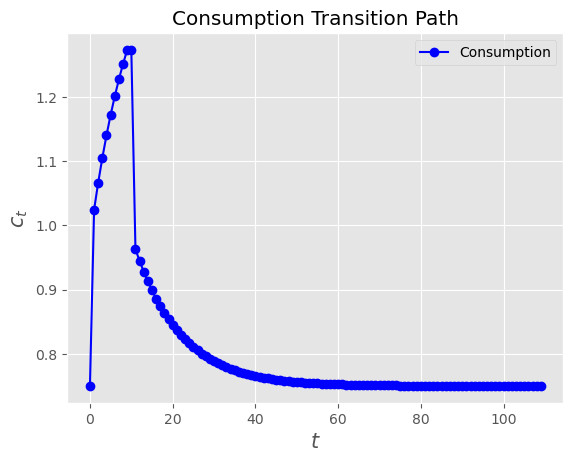

In [4]:
z=1/((k_i**(1 - θ) * h ** θ) ** (1/θ)) 
def transition_path_back(k,n=n):
    "This function returns the transition path towards the steady state over n periods"
    k[0] = k_trans[9]       # Initial Capital Level (First Steady State)
    k[n-1] = k_i     # Final Capital Level (Second Steady State)
    
    #Now let's generate the "n" different Euler equations: 
    trans = np.zeros(n)
    for i in range(n-2):
        if i == (n-2): #Since the other function is not well defined at n-2
            trans[i+1] = k[i+1]**(1-θ)*(z*h)**θ+(1-δ)*k[i+1]-k_i-β*(k[i]**(1-θ)*(z*h)**θ+(1-δ)*k[i]-k[i+1])*((1-θ)*k[i+1]**(-θ)*(z*h)**θ+1-δ)
        else:
            trans[i+1] = k[i+1]**(1-θ)*(z*h)**θ+(1-δ)*k[i+1]-k[i+2]-β*(k[i]**(1-θ)*(z*h)**θ+(1-δ)*k[i]-k[i+1])*((1-θ)*k[i+1]**(-θ)*(z*h)**θ+1-δ)
    return trans

x0 = np.linspace(4,8,n)                 # Grid of n points between4 and 8, which is the transition space. 
k_back = fsolve(transition_path_back,x0)


y_back = output(k_back,y_i=y[9])
## Investment: 
i_back = investment(k_back,i_i=i_path[9])
## Consumption: 
c_back = consumption(y_back,i_back)

k_trans = np.concatenate((k_trans[:10],k_back))
y = np.concatenate((y[:10],y_back))
i_path = np.concatenate((i_path[:10],i_back))
c = np.concatenate((c[:10],c_back))

# plot
create_plots()

# Stationary Economy Value Function Iteration

Consider a Stationary economy populated by a large number of identical infinitely lived households that maximize: 
\begin{align*}
    E_0 \bigg\{ \sum_{t=0}^\infty \beta^t u(c_t,h_t)\bigg\}
\end{align*}
over consumption and leisure $u(c_t,1-h_t) = \ln c_t - \kappa\frac{h_t^{1+\frac{1}{\nu}}}{1+\frac{1}{\nu}}$ subject to:
\begin{align*}
    c_t + i_t =y_t
\end{align*}
\begin{align*}
    y_t= k_t^{1-\theta} (h_t)^{\theta}
\end{align*}
\begin{align*}
    i_t = k_{t+1} - (1-\delta) k_t
\end{align*}

Set $\theta=.679$,$\beta=.988$, $\delta=.013$. Also, to start with, set $h_t=1$, that is, labor is inelastically supplied. To compute the steady-state normalize output to one. 

### Write the problem in recursive formulation

1. State Variable: $k$
2. Choice Variables: $k',c$

\begin{align*}
    V(k) = \max_{\{k',c\} \in A} \ln c_t -\kappa \frac{1}{1+\frac{1}{\nu}} + \beta V(k')
\end{align*}
where:
\begin{align*}
    A= \{(k',c) | c+i = y , y = k^{1-\theta}, i_t = k'-(1-\delta)k , c >0 \}
\end{align*}

So we can rewrite the problem as: 
\begin{align*}
    V(k) = \max_{\{k'\} \in [0,k^{1-\theta}+(1-\delta)k)} \ln (k^{1-\theta}-k'+(1-\delta)k) -\kappa \frac{1}{1+\frac{1}{\nu}} + \beta V(k')
\end{align*}

Notice that it is interesting to find the value of $k$ at the steady state to define our grid properly. To do so I will characterize the Euler equation in sequential form and then impose stationary.  The problem is: 

\begin{align*}
    \max_{k_{t+1}} \sum_{t=0}^\infty \beta^t \left(\ln (k_t^{1-\theta} + (1-\delta)k_t -k_{t+1}) -\frac{\kappa}{1+\frac{1}{\nu}}\right)
\end{align*}
the Foc gives: 
\begin{align*}
\frac{\partial}{\partial k_{t+1}} = 0 \Longleftrightarrow  \frac{\beta^{t+1}( (1-\theta) k_{t+1}^{-\theta}+1-\delta)}{(k_{t+1}^{1-\theta} + (1-\delta)k_{t+1} -k_{t+2})}
=\frac{\beta^t}{(k_t^{1-\theta} + (1-\delta)k_t -k_{t+1})}
\end{align*}

And now if we impose stationary we get:
\begin{align*}
    \beta ((1-\theta)k^{-\theta}+1-\delta)=1  \Longleftrightarrow k_{ss} =\left( \frac{1-\theta}{\frac{1}{\beta} - 1 + \delta}\right)^{\frac{1}{\theta}} 
\end{align*}

And now, we can discretize $k$ in a grid with $k_{max}$ slightly above the steady state.

#### Solve with brute force iterations of the value function. Plot your value function.

In [111]:
!pip install quantecon

     -------------------------------------- 206.9/206.9 kB 4.2 MB/s eta 0:00:00


Number of iterations: 519
TOC: Elapsed: 0:00:14.83
Algoritham takes 14.831 seconds to run
42.552547163136246


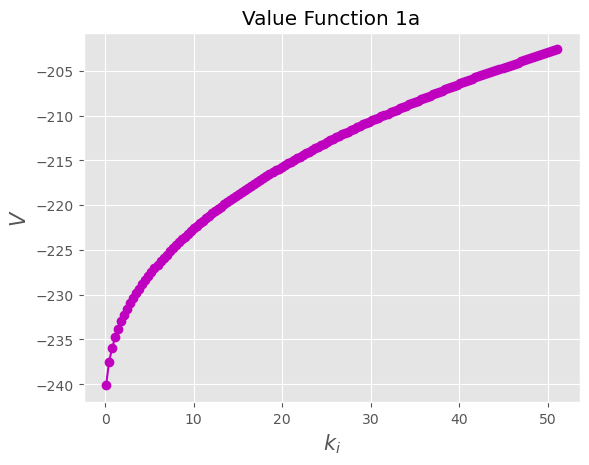

In [6]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

# Define the parameters: 

theta = 0.679
beta = 0.988
delta = 0.013
kappa = 5.24
nu = 2

# To start set h_t=1. Also define K at the Steady State. 

h = 1                                               # Inelastic labor supply

kss = ((1-theta)/((1/beta)-1+delta)) ** (1/theta)   # Steady State Capital

# STEP 1. Discretize the continous variable k: 

n = 150             # Number of discrete point to evaluate

kmin = 0.1          # Initial Grid value (slightly higher than 0 following the lecture notes)

kmax = 1.2*kss      # Maximal Grid Value (20% Above Steady State)

grid = np.linspace(kmin,kmax,n)   # Discrete grid of k

# STEP 2. I make the guess V^{s=0}(k_i)=0.

V = np.zeros(shape=(1,n))    # Initial Guess

# STEP 3 & 4. Generate the return matrix M. Not all values of c are feasible. 

# Generate a function that will evaluate the current utility, that is u(f(k_i)+(1-delta)k_i-k_j): 

def utility (k1,k2):
    "This function returs the utility given k_i and k_j with the form u() = ln(k1^{1-θ} + (1-δ)k1-k2)"
    # Inputs:
        #--> Capital today:    k1
        #--> Capital tomorrow: k2
        
    u = np.log(k1**(1-theta)+ (1-delta)*k1 - k2) - (kappa/(1+(1/nu)))
    return u

# As suggested by the slides I will change not feasible values by a very negative number omega:

omega = -1000 

# Define a function that gives the maximum k_j feasible given k_i
def feasible(k1):
    "Returns the maximum feasible k_j given k_i with the form : f(k_i)+(1-δ)k_i"
    # Inputs:
        #--> Capital today:    k1
    f = k1**(1-theta)+ (1-delta)*k1
    return f

# Generate the matrix M following the lecture notes : 

M = np.zeros(shape=(n,n))     # Empty matrix that later will become the utility evaluated at every possible combination of k_i and k_j

for i in range(n):
    for j in range(n):
        if feasible(grid[i]) >= grid[j]: 
            M[i][j] = utility(grid[i],grid[j])    # Gives the element ij of matrix M
        else: 
            M[i][j] = omega

# Important !! --> I have to do Step 3 and 4 at the same time since the log of a negative value is not well defined, so I have to prevent this. 


# STEP 5 & 6. Compute the matrix X. Solve for V^{s+1} and check for tolerance.

epsilon = 0.005    # Tolerance level.

def VFI(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()                       # Starts to count the time this functions takes to run
    
    X  = np.zeros(shape=(n,n))     # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    
    # Loop to generate X:
    for i in range(n):
        for j in range(n):
            X[i][j] = M[i][j] + beta*V[0][j]
    
    # Get the max of all the possible X[i] given j:

    for i in range(n):
        Vnew[0][i] = np.amax(X[i][:])     # New iteration for V
    
    # Generate the new value function and repeat the process until tolerance is satisfied:
    
    count=0                                 # Will count the number of iterations
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        for i in range(n):
            for j in range(n):         
                X[i][j] = M[i][j] + beta*Vnew[0][j]
    
        for i in range(n):    
            Vnew[0][i] = np.amax(X[i][:])
        count +=1
 
    print('Number of iterations: '+str(count)) 
    
    T = qe.toc()     # Stops counting time
    
    print('Algoritham takes '+ str(round(T,3)) + ' seconds to run')
    return V
    
ValueFunction1 = VFI(M,V,epsilon).T


# Plot Value Function:

fig, ax = plt.subplots()
ax.plot(grid,ValueFunction1,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 1a")

print(kss)

## The speed of the iteration is fundamental. Let's try to improve our algorithm: 

#### Iterations of the value function taking into account monotonicity of the optimal decision rule. 
Now the intention is to reduce the number of points to be searched on the grid by the VFI algorithm. We know that the optimal decision rule increases in k. Therefore, if $k_j>k_i$, then $g(k_j) \geq g(k_i)$. For this reason we know that if we want to find $g(k_j)$ when $k_j>k_i$ we can rule out searching for all grid values of capital that are smaller than $g(k_i)$.
#### Iterations of the value function taking into account concavity of the value function. 
It is known that the maximand in the Bellman equation, $M_{i,j} + \beta V_j$, is strictly concave in $k'$. Therefore, if $M_{i,j} + \beta V_j>M_{i,j+1} + \beta V_{k+1}$, then $M_{i,j} + \beta V_j>M_{i,j+2} + \beta V_{k+2}$. Therefore, to make more efficient our algorithm we can include this condition.
#### Iterations of the value function taking into account local search on the decision rule. 
We know that if $k_j = g(k_i)$ then it is reasonable to think that $g(k_{i+1})$ is in a small neigborhood of $k_j$.